# 1. Import all libraries

In [4]:
import numpy as np
import pandas as pd
import pandas_profiling
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc, accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# DATA_PATH = '/kaggle/input/sf-dst-scoring/'
DATA_PATH = '.'

RANDOM_STATE = 42

In [5]:
# the additional functions that can be useful during the analysis
def vis_num_feature(
    data: pd.DataFrame, 
    column: str
):
    plt.style.use('seaborn-paper')
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    data[column].plot.hist(ax=ax[0][0])
    ax[0][0].set_title(column)
    sns.boxplot(data=data, y=column, ax=ax[0][1], orient='v')
    np.log2(data[column] + 1).plot.hist(ax=ax[1][0])
    ax[1][0].set_title(f'log2 transformed {column}')
    sns.boxplot(y=np.log2(data[column]), ax=ax[1][1], orient='v')
    plt.show()

def show_stat_outliers(
    data: pd.DataFrame,
    column: str,
    log: bool = False
):
    if log:
        data[column] = np.log2(data[column] + 1)
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    IQR = q3 - q1
    mask25 = q1 - IQR * 1.5                   
    mask75 = q3 + IQR * 1.5

    values = {}
    values['borders'] = mask25, mask75
    values['# outliers'] = data[(data[column] < mask25)].shape[0], data[data[column] > mask75].shape[0]

    return pd.DataFrame.from_dict(data=values, orient='index', columns=['left', 'right'])

def plot_all_metrics(
    y_true: np.ndarray, 
    y_pred: np.ndarray, 
    y_pred_prob: np.ndarray, 
    previous_results: list
):
        
    metrics = {}
    acc = accuracy_score(y_true, y_pred)
    metrics['accuracy'] = [acc, previous_results[0] - acc]

    prec = precision_score(y_true, y_pred)
    metrics['precision'] = [prec, previous_results[1] - prec]
    
    rec = recall_score(y_true, y_pred)
    metrics['recall'] = [rec, previous_results[2] - rec]
    
    f1 = f1_score(y_true, y_pred)
    metrics['f1_score'] = [f1, previous_results[3] - f1]
    
    rocauc = roc_auc_score(y_true, y_pred_prob)
    metrics['roc_auc'] = [rocauc, previous_results[4] - rocauc]    
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Metrics value','Difference'])
    
    return metrics_df, metrics_df['Metrics value'].to_list()

def vis_confusion_matrix(
    y_true: np.ndarray, 
    y_pred: np.ndarray,  
    class_names: list
):
    conf_mat = confusion_matrix(y_true, y_pred).T
    df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.show()
    
def vis_roc_curve(
    y_true: np.ndarray, 
    y_pred_prob: np.ndarray,  
):
    plt.style.use('seaborn-paper')
    fpr, tpr, threshold = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(10, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Logistic Regression ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    
def vis_prec_recall_curve(
    y_true: np.ndarray, 
    y_pred_prob: np.ndarray,
):
    plt.style.use('seaborn-paper')
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    auc_score = auc(recalls, precisions)
    lw = 2
    plt.plot(precisions, recalls, lw=lw, label='Area under the curve: %0.3f' % auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")
    plt.show()
    
def vis_train_valid_counts(
    init_data: pd.DataFrame, 
    train: pd.DataFrame, 
    valid: pd.DataFrame
):
    x = np.array([0, 1])
    width = 0.2

    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    
    classes = list(init_data['default'].value_counts().index)
    
    ax.bar(x - width, [len(init_data[init_data.default == each]) for each in classes], width, color='r', label='Исходные данные')
    print([len(train[train == each]) for each in classes], [len(valid[valid == each]) for each in classes])
    ax.bar(x, [len(train[train == each]) for each in classes], width, color='g', label='Тренировочная выборка')
    ax.bar(x, [len(valid[valid == each]) for each in classes], width, bottom=[len(train[train == each]) for each in classes], color='b', label='Валидационная выборка')

    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Кол-во примеров', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)
    plt.show()
    
def vis_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()
    
def fill_outliers_with_q1_q3(
    df: pd.DataFrame,  
    col: str 
): 
    q10 = df[column].quantile(0.1)
    q90 = df[column].quantile(0.9)
    
#     IQR = q3 - q1
#     mask25 = q1 - IQR * 1.5                   
#     mask75 = q3 + IQR * 1.5

    df[col] = df[col].apply(lambda x: q90 if x > q90 else x)
    df[col] = df[col].apply(lambda x: q10 if x < q10 else x)
    
    return df[col]

# 2.Import the data 

In [6]:
# import the data 
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
print(df_train.shape, df_test.shape)

(73799, 19) (36349, 18)


We can observe that the data were split into train and test datasets in the ration two to one (66.7% : 33.3%). For the further work with the dataset we need to combine the train and test data together in one dataset.

--------

Данные были разделены на тренировочный и тестовый датасеты в соотношении 2 к 1 (66.7% : 33.3%). Для дальнейшей работы с данными нам нужно объединить два датасета в один.

In [7]:
df_train['train_data'] = 1
df_test['train_data'] = 0
df = df_train.append(df_test, ignore_index=True, sort=False)
df.shape

(110148, 20)

# 3. EDA

In [8]:
pandas_profiling.ProfileReport(df[df.train_data == 1])

c:\users\voytik\anaconda3\envs\ds\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Based on the pandas_profiling report, we observe the following facts:
 - dataset has 18 features (where 19 is created earlier train_data column to distinguish between train and test data and 20 is the target feature - default);
 - the percent of missing values is < 0.1% (only in the education column) and we don't have duplicated values;
 - according to the report we have 7 numeric columns, 10 categorical ones, and 3 boolean columns. Looking deeper to the data, we can confirm that some categorical columns, such as e.g. sex, good_work, etc., can be converted to binary columns for convenience.
 - some numerical columns, e.g. decline_app_cnt, bki_request_cnt, income, have a right-skewed distribution that is far from the normal one. Solution: we can try to log transform these columns that can help to get a normal distribution for them.
 - client_id column has only unique values and uniform distribution that makes him a candidate to exclude for further analysis;
 ----
Основываясь на отчете pandas_profiling, мы наблюдаем следующие факты:
  - набор данных имеет 18 признаков (где 19-ый созданный ранее столбец train_data, чтобы различать тренировачные и тестовые данные, а 20 - целевая переменная default);
  - процент пропущенных значений <0,1% (только в столбце education) и у нас нет повторяющихся значений;
  - согласно отчету у нас 7 числовых столбцов, 10 категориальных и 3 бинарных столбца. Заглянув глубже в данные, мы можем подтвердить, что некоторые категориальные столбцы, такие как, например, sex, good_work, и т.д., для удобства можно преобразовать в бинарные столбцы.
  - некоторые числовые столбцы, например reduce_app_cnt, bki_request_cnt, income, имеют искаженное вправо распределение, которое далеко от нормального. Решение: мы можем попытаться преобразовать эти столбцы логарифмически, чтобы получить для них нормальное распределение. 
  - столбец client_id имеет только уникальные значения и равномерное распределение, что делает его кандидатом для исключения из дальнейшего анализа.
 
Columns description | Описание столбцов:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

Let's split all existing in the dataset columns into binary, categorical and numerical. The client_id column is excluded from the analysis.

----
Для того, что анализировать данные далее по группам, объединим столбцы в категориальные, бинарные и числовые столбцы. Столбец client_id исключен из анализа.

In [9]:
dt_cols = ['app_date']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address',  'region_rating', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
len(dt_cols + bin_cols + cat_cols + num_cols)

17

## 3.1. DT_COLUMNS analysis

In [10]:
df[dt_cols]

app_date
0       01FEB2014
1       12MAR2014
2       01FEB2014
3       23JAN2014
4       18APR2014
...           ...
110143  31MAR2014
110144  25APR2014
110145  30MAR2014
110146  07JAN2014
110147  17MAR2014

[110148 rows x 1 columns]

For further convenient work with the data we need to convert to dt format:

----
Для дальнейшей удобной работы с данными нам необходимо преобразовать их в формат dt:

In [11]:
df.app_date = pd.to_datetime(df.app_date)

In [13]:
# feature engineering
df['weekend'] = df.app_date.apply(lambda x: 1 if x.day_of_week >= 5 else 0)
df['month '] = df.app_date.dt.month

## 3.2. BIN_COLUMNS analysis

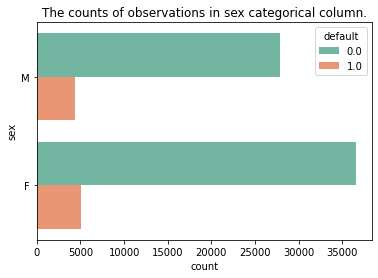

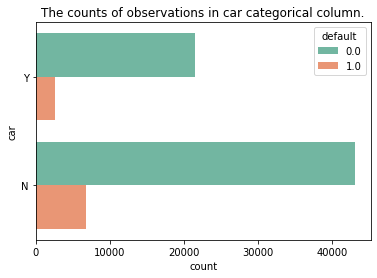

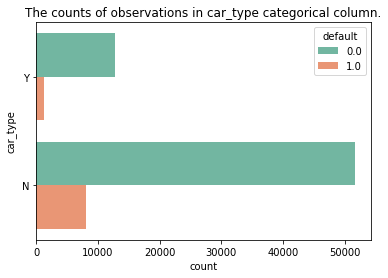

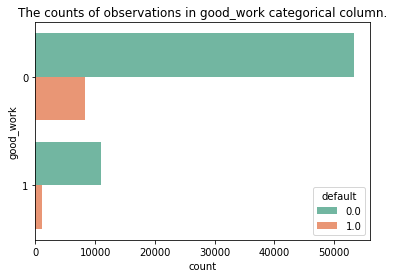

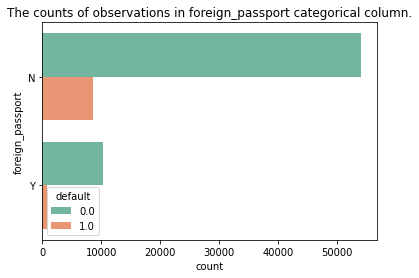

In [14]:
for each in bin_cols:
    sns.countplot(data=df, y=each, hue='default', palette="Set2");
    plt.title(f'The counts of observations in {each} categorical column.')
    plt.show()

For binary columns apply **LabelEncoder**.

---
Для бинарных столбцов применим **LabelEncoder**.

In [15]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column]) 

Feature engineering: We can see that some features, such as foreign_passport, good_work and car_type, show similar behaviour and have a big influence on the target feature 'default'. We can try to combine them in one feature and to help the model in the feature.

----
Генерация новых признаков: мы видим, что некоторые функции, такие как foreign_passport, good_work и car_type, демонстрируют аналогичное поведение и имеют большое влияние на целевую функцию по умолчанию. Мы можем попытаться объединить их в один признак.

In [16]:
df['successful_customer'] = (df['foreign_passport'] + 1) * (df['good_work'] + 1) * (df['car_type'] + 1)
cat_cols.append('successful_customer')

In [17]:
df.head()

client_id   app_date education  sex  age  car  car_type  decline_app_cnt  \
0      25905 2014-02-01       SCH    1   62    1         1                0   
1      63161 2014-03-12       SCH    0   59    0         0                0   
2      25887 2014-02-01       SCH    1   25    1         0                2   
3      16222 2014-01-23       SCH    0   53    0         0                0   
4     101655 2014-04-18       GRD    1   48    0         0                0   

   good_work  score_bki  ...  work_address  income  sna  first_time  \
0          0  -2.008753  ...             2   18000    4           1   
1          0  -1.532276  ...             3   19000    4           1   
2          0  -1.408142  ...             2   30000    1           4   
3          0  -2.057471  ...             3   10000    1           3   
4          1  -1.244723  ...             3   30000    1           4   

   foreign_passport  default  train_data  weekend  month   successful_customer  
0                 0      0.0           1        1       2                    2  
1                 0      0.0           1        0       3                    1  
2                 1      0.0           1        1       2                    2  
3                 0      0.0           1        0       1                    1  
4                 1      0.0           1        0       4                    4  

[5 rows x 23 columns]

## 3.3. CAT_COLUMNS analysis

In the categorical columns is our education column with the missing values. Let's replace the missing values with the most common value:

----
В категориальных столбцах находится столбец Образование с пропущенными значениями. Заменим пропущенные значения на наиболее распространенное значение.

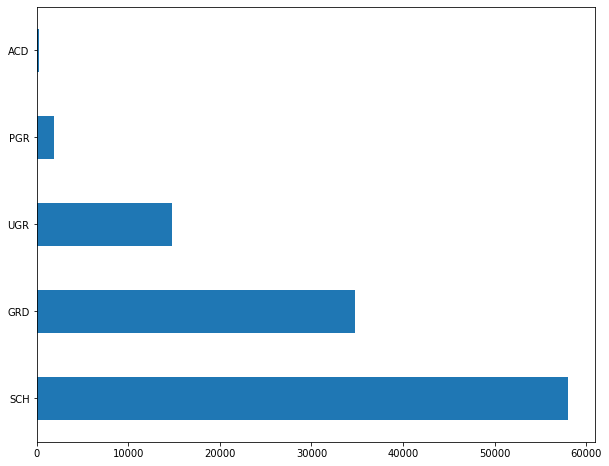

In [18]:
plt.figure(figsize=(10, 8))
df.education.value_counts().plot(kind='barh');

Fill the missing values with the most often present education value: 'SCH' - and check the missing values in the whole dataset.

----
Заполним пропущенные значения наиболее часто встречающимся значением в столбце Образование: «SCH» - и проверим отсутствующие значения во всем наборе данных.

In [19]:
df.education.fillna(value=df.education.value_counts().index[0], axis=0, inplace=True)
df.isna().sum()

client_id                  0
app_date                   0
education                  0
sex                        0
age                        0
car                        0
car_type                   0
decline_app_cnt            0
good_work                  0
score_bki                  0
bki_request_cnt            0
region_rating              0
home_address               0
work_address               0
income                     0
sna                        0
first_time                 0
foreign_passport           0
default                36349
train_data                 0
weekend                    0
month                      0
successful_customer        0
dtype: int64

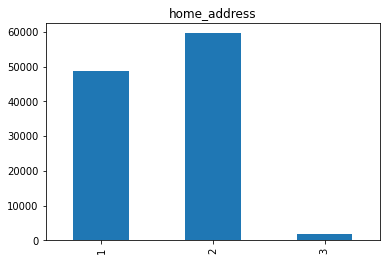

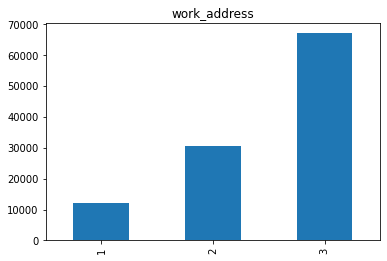

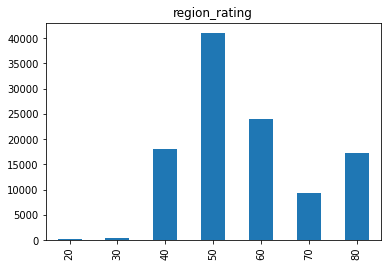

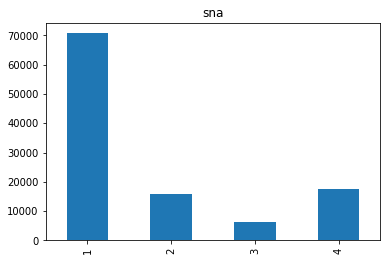

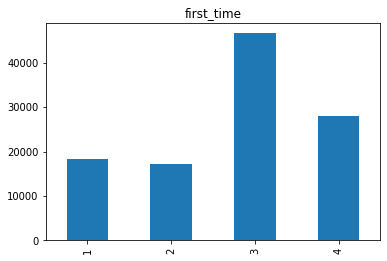

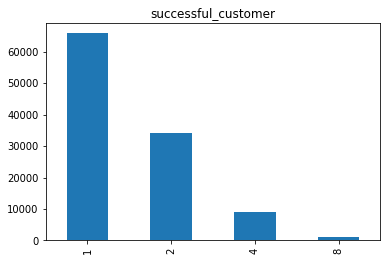

In [20]:
for each in cat_cols[1:]:
    df[each].value_counts().sort_index(ascending=True).plot(kind='bar')
    plt.title(each)
    plt.show();

Feature engineering: let's create a new categorical feature.

<AxesSubplot:>

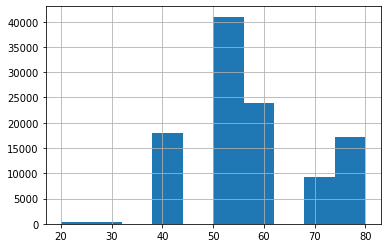

In [21]:
df.region_rating.hist()

In [22]:
def convert_region_rating(rating):
    if rating < 40:
        return 'low'
    elif rating >= 40 and rating <= 60:
        return 'medium'
    else: 
        return 'high'

df['region_rating_cat'] = df.region_rating.apply(convert_region_rating)
cat_cols.append('region_rating_cat')

Apply a **One-Hot-Encoding** for the categorical values using the **get_dummies** function.

----
Применим **One-Hot-Encoding** для категориальных значений с помощью функции **get_dummies**.

In [23]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [24]:
df.columns

Index(['client_id', 'app_date', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'income', 'foreign_passport', 'default', 'train_data', 'weekend',
       'month ', 'education_GRD', 'education_PGR', 'education_SCH',
       'education_UGR', 'home_address_2', 'home_address_3', 'work_address_2',
       'work_address_3', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80', 'sna_2', 'sna_3', 'sna_4', 'first_time_2',
       'first_time_3', 'first_time_4', 'successful_customer_2',
       'successful_customer_4', 'successful_customer_8',
       'region_rating_cat_low', 'region_rating_cat_medium'],
      dtype='object')

## 3.4. NUM_COLUMNS analysis

Let's look at the distribution of the numerical columns.

---
Посмотрим на распределение числовых столбцов.

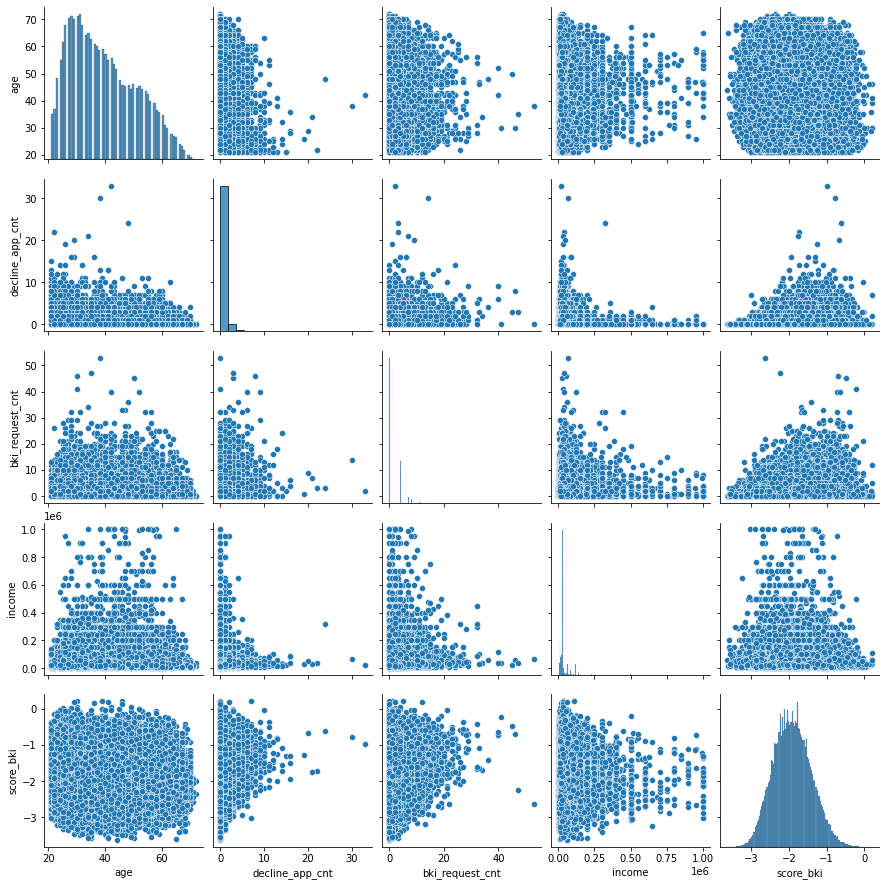

In [25]:
sns.pairplot(df[num_cols])

Especially for 3 out of 5 features have a right-skewed distribution far from the normal one. Let's log transform the data that can help in this case and find the number of outliers from both sides of thresholds (q1 - 1.5 IQR, q3 + 1.5 IQR).

----
В частности, для 3 из 5 функций распределение далеко от нормального и смещено вправо. Трансформируем данные этих столбцов логарифмированием, чтобы посмотреть меняется ли распределение, а также найдем число выбросов с каждой стороны от левого и правого порога (q1 - 1.5 IQR, q3 + 1.5 IQR).

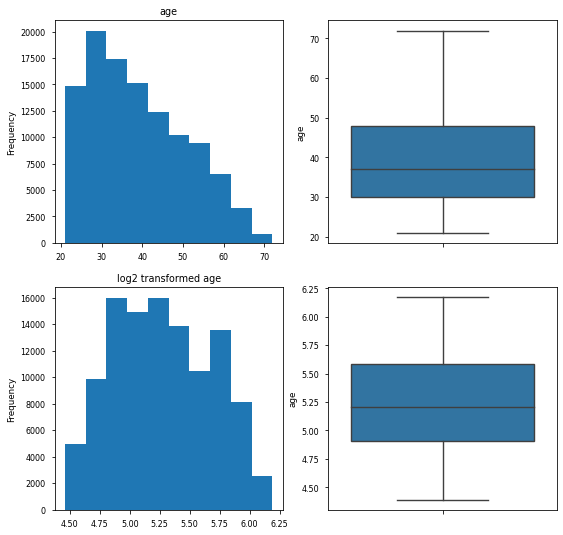

left    right
borders     3.963426  6.60548
# outliers  0.000000  0.00000


----------



c:\users\voytik\anaconda3\envs\ds\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\voytik\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


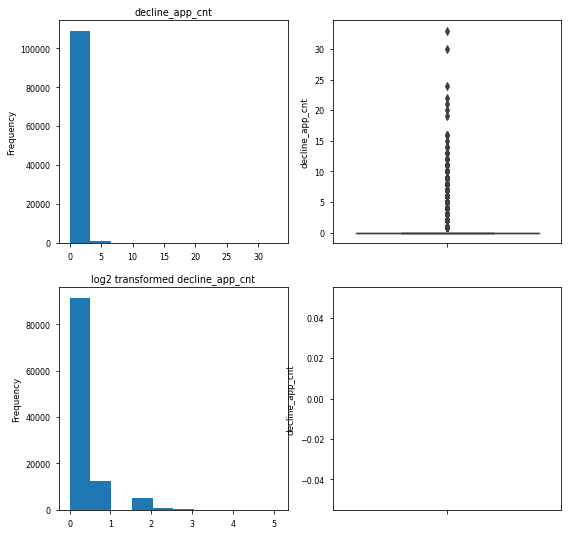

left    right
borders      0.0      0.0
# outliers   0.0  18677.0


----------



c:\users\voytik\anaconda3\envs\ds\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\voytik\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


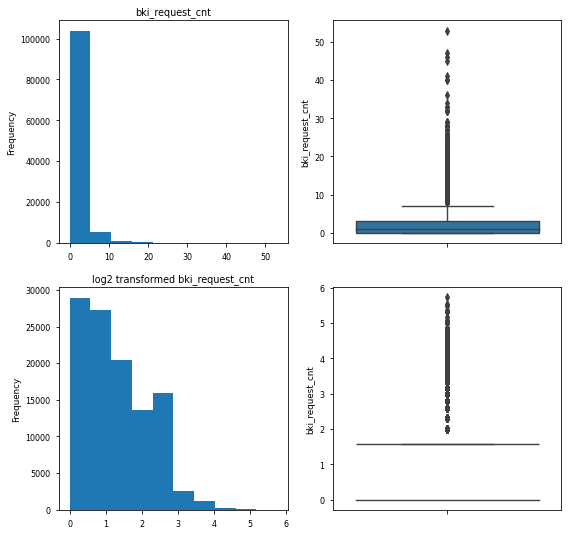

left  right
borders     -3.0    5.0
# outliers   0.0   15.0


----------



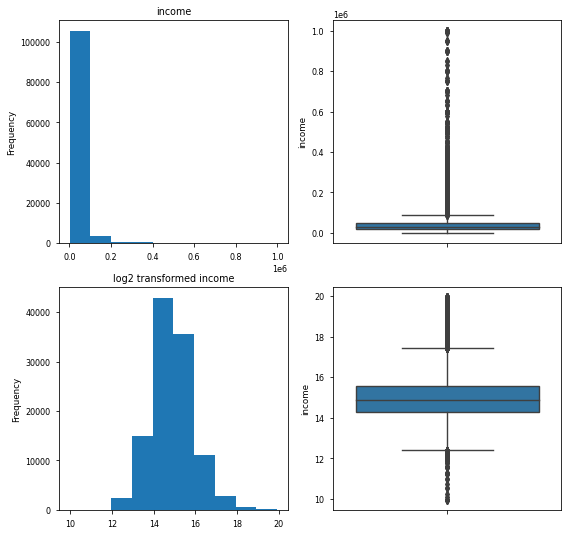

left        right
borders      12.393296    17.445265
# outliers  875.000000  1734.000000


----------



c:\users\voytik\anaconda3\envs\ds\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


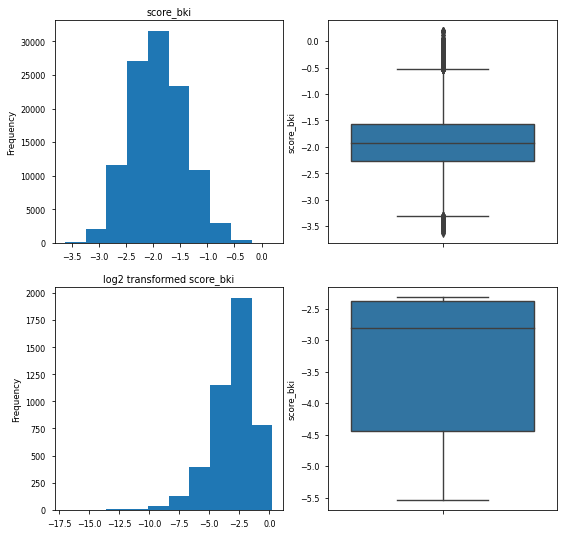

left      right
borders     -3.299252   -0.52907
# outliers  82.000000  436.00000


----------



In [26]:
for each in num_cols:
    vis_num_feature(df, each)
    if each == 'score_bki':
        display(show_stat_outliers(df, each))
    else:
        display(show_stat_outliers(df, each, log=True))
    print('\n' + '-' * 10 + '\n')

Features:
- age: the log-normal distribution, no outliers;
- decline_app_cnt: the distribution looks better after log2 transformation, a lot of outliers on the right side - let's leave them for now;
- bki_request_cnt: the log-normal distribution, no outliers;
- income: the log-normal distribution, a lot of outliers on both sides - let's leave them for now;
- score_bki: the normal distribution (no need to log-transform), some outliers on both sides - let's leave them for now;

We can see that for some features log2 transformation helps to resolve the issue with the distribution, therefore let's transform the features for further analysis.

----
Признаки:
- age: логнормальное распределение, без выбросов;
- decline_app_cnt: распределение выглядит лучше после преобразования log2, много выбросов справа - оставим их пока;
- bki_request_cnt: логнормальное распределение, без выбросов;
- income: логнормальное распределение, много выбросов с обеих сторон - пока оставим их;
- score_bki: нормальное распределение (лог-преобразование не требуется), некоторые выбросы с обеих сторон - пока оставим их;

Мы видим, что для некоторых функций преобразование log2 помогает решить проблему с распределением, поэтому преобразуем функции для дальнейшего анализа. 

In [27]:
df.decline_app_cnt.describe()

count    110148.000000
mean          0.218323
std           0.521290
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.087463
Name: decline_app_cnt, dtype: float64

In [28]:
df['decline_app_cnt_cat'] = df['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
cat_cols.append('decline_app_cnt_cat')

In [29]:
df.decline_app_cnt = fill_outliers_with_q1_q3(df, 'decline_app_cnt')

In [30]:
for each in num_cols[:-1]:
    df[each] = np.log2(df[each] + 1) 

Coming back here after training and improving the model, we need to delete or replace the outliers that we found. Inspired by the ideas in the [Cleaning up data from outliers](https://www.pluralsight.com/guides/cleaning-up-data-from-outliers) we deal again with the outliers. For this let's calculate the skewness value for the columns left with outliers.

---
Вернувшись сюда после обучения и улучшения модели, нам нужно удалить или заменить выбросы, которые мы обнаружили. Вдохновленные идеями из раздела [Cleaning up data from outliers](https://www.pluralsight.com/guides/cleaning-up-data-from-outliers), мы снова имеем дело с выбросами. Для этого рассчитаем значение асимметрии для столбцов, оставшихся с выбросами.

In [31]:
for each in ['decline_app_cnt', 'income', 'score_bki']:
    print(f'Skewness value for the column {each} is {df[each].skew()}.')

Skewness value for the column decline_app_cnt is 1.7611900602847503.
Skewness value for the column income is 0.08882434164942392.
Skewness value for the column score_bki is 0.19398729756537827.


We see that the values for 'income' and 'score_bki' columns are changed after the log transformation and are now in the range between -1 and 1. The skewness value for the 'decline_app_cnt' column is still high. Let's replace the outliers in this column with the the 10th and 90th percentiles before doing log transformation.
Here we can also try to create a categorical feature using 'decline_app_cnt' column before log transformation. 

----
Мы видим, что значения столбцов «income» и «score_bki» изменились после log преобразования и теперь находятся в диапазоне от -1 до 1. Значение асимметрии для столбца «decline_app_cnt» по-прежнему велико. Давайте заменим выбросы в этом столбце 10 и 90 квартилем перед log-преобразованием.
Здесь мы также можем попытаться создать категориальную признак, используя столбец Dec_app_cnt, до логарифмирования.

Let's add polinomial features.

----
Добавим полиномиальные признаки.

In [32]:
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df, how='left')

## 3.5. Default target value

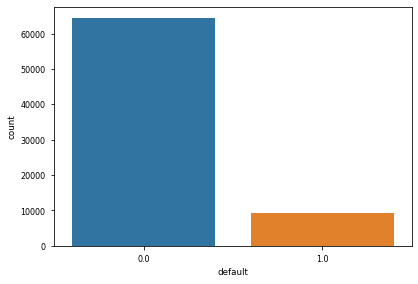

In [33]:
sns.countplot(data=df[df.train_data == 1], x='default');

The training dataset is imbalanced. In this case we shouldn't use an accuracy metric to evaluate the quality of the data and choose a confusion matrix, precision, recall, F1-score, ROC-curves.

----
Набор обучающих данных несбалансирован. В этом случае мы не должны использовать метрику точности для оценки качества данных и выбираем confusion matrix, precision, recall, F1-score, ROC-curves.

## 3.6. Common analysis

### Correlation analysis of the numerical features

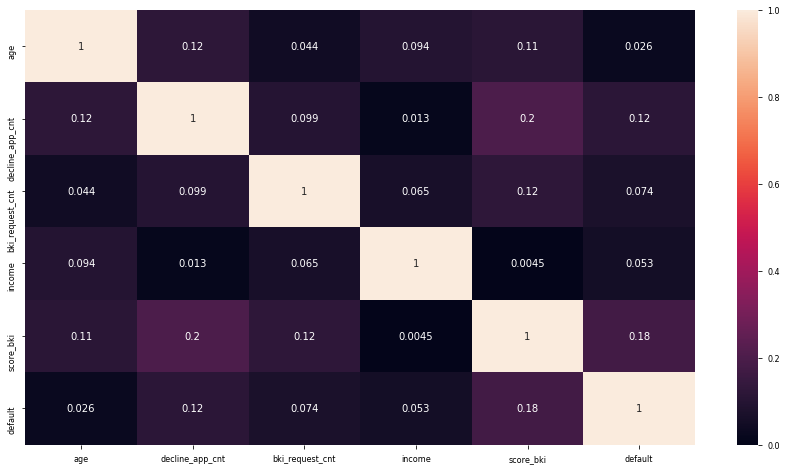

In [34]:
plt.figure(figsize=(15, 8));
sns.heatmap(df[df.train_data == 1][num_cols + ['default']].corr().abs(), vmin=0, vmax=1, annot=True);

We don't observe any highly correlated values. We'll use all features further.

Let's evaluate the importance of the numerical values by performing a univariate feature selection. Univariate feature selection works by selecting the best features based on univariate statistical tests.

---

Мы не наблюдаем каких-либо сильно скоррелированных значений. Мы будем использовать все признаки дальше.

Оценим важность числовых значений, выполнив одномерный выбор признаков. Одномерный выбор признаков работает путем выбора лучших признаков на основе одномерных статистических тестов. 

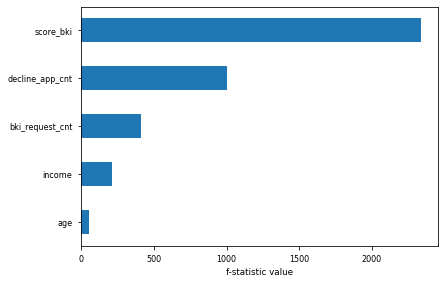

In [35]:
imp_num = pd.Series(f_classif(df[df.train_data == 1][num_cols], df[df.train_data == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.xlabel('f-statistic value');

Features with higher f-statistic values, such as score_bki and decline_app_cnt, are more significant for our linear model.
Let's perform the standardization of the numeric data. We will fit only train test data and transform both train and test.

----
Функции с более высокими значениями f-статистики, такие как score_bki и reduce_app_cnt, более значимы для нашей линейной модели.
Выполним стандартизацию числовых данных. Для этого мы используем только тренировочные данные, а преобразуем как тренировочные, так и тестовые.

In [36]:
std_scaler = StandardScaler()
df[df.train_data == 1][num_cols] = std_scaler.fit_transform(df[df.train_data == 1][num_cols])
df[df.train_data == 0][num_cols] = std_scaler.transform(df[df.train_data == 0][num_cols])

<ipython-input-36-83ca32f5ca49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.train_data == 1][num_cols] = std_scaler.fit_transform(df[df.train_data == 1][num_cols])
c:\users\voytik\anaconda3\envs\ds\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-36-83ca32f5ca49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [37]:
df[df.train_data == 1][num_cols].describe()

age  decline_app_cnt  bki_request_cnt        income  \
count  73799.000000     73799.000000     73799.000000  73799.000000   
mean       2.646170         0.170531         1.033155      3.990449   
std        0.094763         0.376101         0.682944      0.090729   
min        2.448751         0.000000         0.000000      3.455127   
25%        2.573907         0.000000         0.000000      3.934307   
50%        2.643378         0.000000         1.000000      3.988478   
75%        2.725678         0.000000         1.584963      4.048827   
max        2.845957         1.000000         2.755932      4.387609   

          score_bki  
count  73799.000000  
mean      -1.904724  
std        0.498231  
min       -3.624586  
25%       -2.259534  
50%       -1.920823  
75%       -1.569831  
max        0.199773

# 4. Build a ML model 

In [38]:
train_data = df[df.train_data == 1].drop(['train_data', 'client_id', 'app_date'], axis=1)
test_data = df[df.train_data == 0].drop(['train_data', 'client_id', 'app_date'], axis=1)

In [39]:
X = train_data.drop('default', axis=1).values
y = train_data['default'].values

In [40]:
# split the data into the train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(59039, 53) (14760, 53) (59039,) (14760,)


In [41]:
previous_results = np.zeros(5)
previous_results

array([0., 0., 0., 0., 0.])

In [42]:
# build a model and train/predict the data
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_prob = log_reg.predict_proba(X_valid)[:, 1]
y_pred = log_reg.predict(X_valid)

In [43]:
curr_metrics, previous_results = plot_all_metrics(y_valid, y_pred, y_pred_prob, previous_results)
display(curr_metrics)

Metrics value  Difference
accuracy        0.875474   -0.875474
precision       0.438202   -0.438202
recall          0.021346   -0.021346
f1_score        0.040710   -0.040710
roc_auc         0.743475   -0.743475

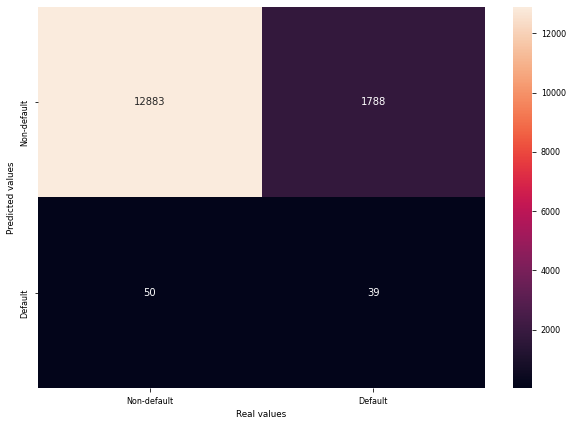

In [44]:
vis_confusion_matrix(y_valid, y_pred, ['Non-default', 'Default'])

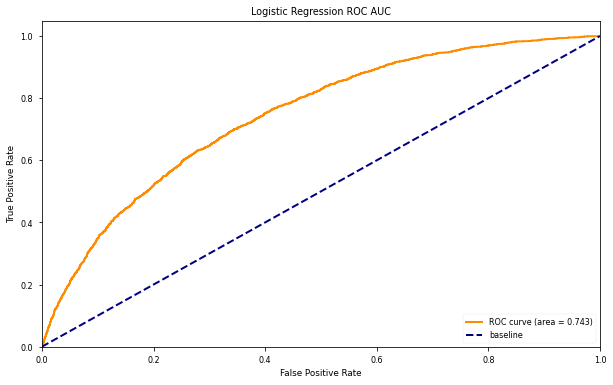

In [45]:
vis_roc_curve(y_valid, y_pred_prob)

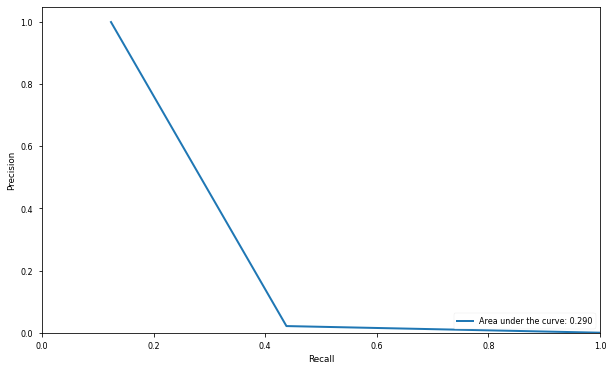

In [46]:
vis_prec_recall_curve(y_valid, y_pred_prob)

[train] F1-score = 0.05 +/- 0.01
[valid] F1-score = 0.05 +/- 0.02


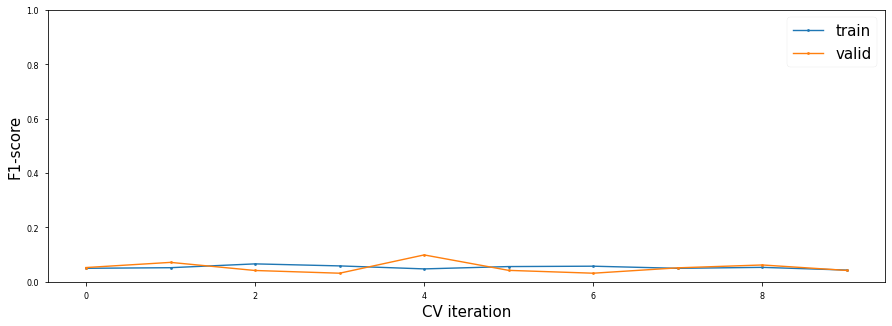

In [47]:
cv_metrics = cross_validate(log_reg, X_valid, y_valid, cv=10, scoring='f1', return_train_score=True)
vis_cv_metrics(cv_metrics)

To summarize the information:
* looking at the different metrics we can see that some of them are relatively high: accuracy and roc_curve. But as we have unbalanced data it's a good case when we shouldn't use these metrics further.
* we see an extremely low recall value that shows the number of TP values among all P and it gives us a hint that we have a lot of FN values and the high type II error. For further convenience, it's better to look at the f1-score and on the area under the Precision-Recall curve.

The further plan to improve the model would be:
- try to optimize the hyperparameters of the model;
- balance the data;
- feature engineering;

---
Обобщая информацию:
* глядя на различные метрики, мы видим, что некоторые из них относительно высоки: точность и roc_curve. Но поскольку у нас несбалансированные данные, это хороший пример, когда мы не должны использовать эти метрики в дальнейшем.
* мы видим чрезвычайно низкое значение recall, которое показывает количество значений TP среди всех P, и это дает нам подсказку, что у нас много значений FN и высокая ошибка второго типа. Для большего удобства лучше смотреть на показатель f1 и на область под кривой Precision-Recall.

Дальнейший план улучшения модели:
- попробовать оптимизировать гиперпараметры модели;
- сбалансировать данные;
- добавление новых признаков;

## 4.1. Hyperparameters optimization

In [48]:
# Create param grid.
# param_grid = [
#     {'penalty': ['l1', 'l2'],
#     'C': np.logspace(-4, 4, 20),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#      'class_weight': ['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#     }
# ]

# # Create grid search object
# clf = GridSearchCV(log_reg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

# # Fit on data
# clf.fit(X_train, y_train)
     
# model = clf.best_estimator_

# # Print parameters
# best_parameters = model.get_params()
# for param in sorted(model.get_params().keys()):
#     print(param, best_parameters[param], '\n')

# # Print metrics     
# y_pred = model.predict(X_valid)
# y_pred_proba = model.predict_proba(X_valid)

print(
"""
C 0.012742749857031334 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 500 

multi_class auto 

n_jobs None 

penalty l2 

random_state 42 

solver liblinear 

tol 0.0001 

verbose 0 

warm_start False 
"""
)


C 0.012742749857031334 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 500 

multi_class auto 

n_jobs None 

penalty l2 

random_state 42 

solver liblinear 

tol 0.0001 

verbose 0 

warm_start False 



In [49]:
# print(f'Precision: {precision_score(y_valid, y_pred):.4f}')
# print(f'Recall: {recall_score(y_valid, y_pred):.4f}')
# print(f'F1 score: {f1_score(y_valid, y_pred):.4f}')

All our scores are better in comparison to the previous results. Let's train the model.

----
Все наши метрики лучше по сравнению с предыдущими результатами. Обучим новую модель.

In [50]:
# train our second model with new parameters and let's look at the metrics
log_reg2 = LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=500,
    C=0.012,
    class_weight= 'balanced', 
    dual= False, 
    fit_intercept= True, 
    intercept_scaling= 1, 
    l1_ratio= None, 
    multi_class= 'auto', 
    n_jobs= None, 
    penalty= 'l2', 
    solver = 'liblinear',
    tol=0.0001,
    verbose= 0, 
    warm_start= False
)
log_reg2.fit(X_train, y_train)
y_pred_prob = log_reg2.predict_proba(X_valid)[:, 1]
y_pred = log_reg2.predict(X_valid)

Metrics value  Difference
accuracy        0.667344    0.208130
precision       0.225076    0.213126
recall          0.690750   -0.669403
f1_score        0.339521   -0.298811
roc_auc         0.743663   -0.000188

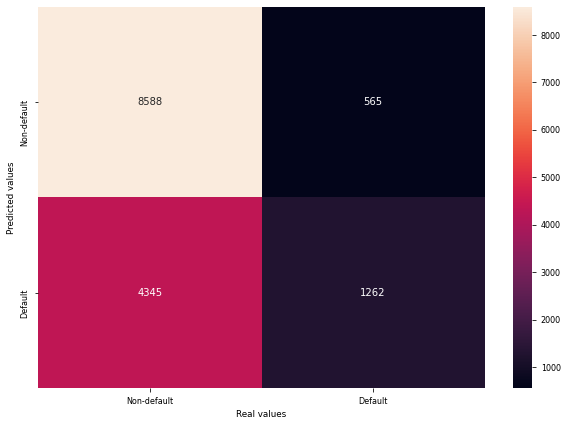

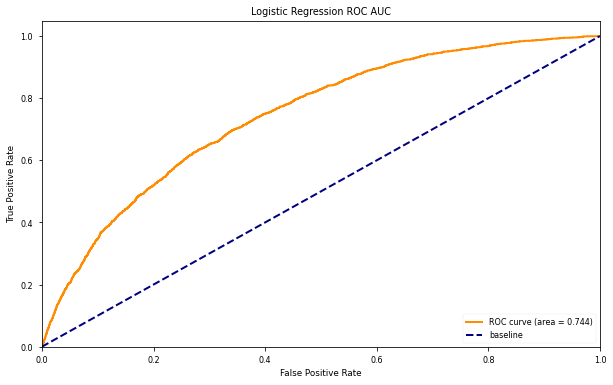

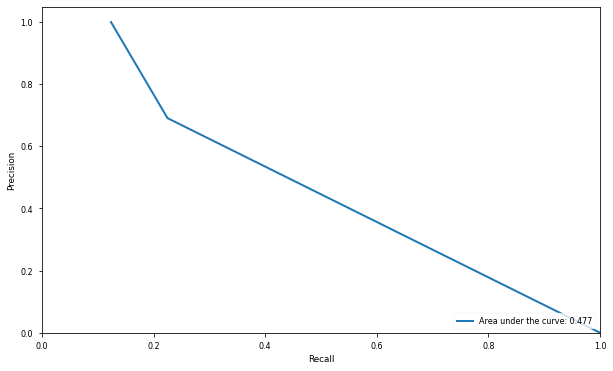

[train] F1-score = 0.34 +/- 0.00
[valid] F1-score = 0.34 +/- 0.02


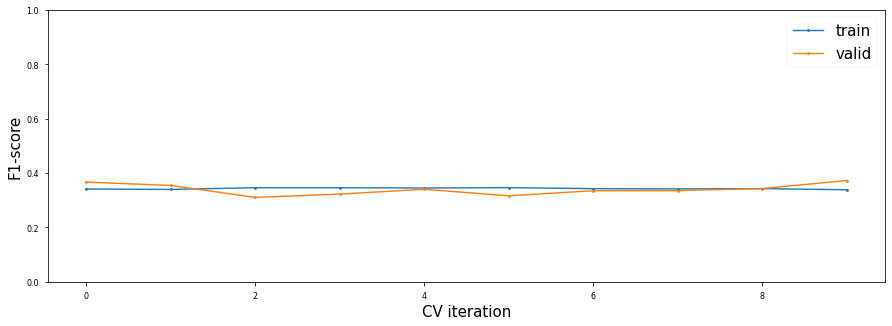

In [51]:
curr_metrics, previous_results = plot_all_metrics(y_valid, y_pred, y_pred_prob, previous_results)
display(curr_metrics)
vis_confusion_matrix(y_valid, y_pred, ['Non-default', 'Default'])
vis_roc_curve(y_valid, y_pred_prob)
vis_prec_recall_curve(y_valid, y_pred_prob)
cv_metrics = cross_validate(log_reg2, X_valid, y_valid, cv=10, scoring='f1', return_train_score=True)
vis_cv_metrics(cv_metrics)

Now we can see that the recall, f1-score and Precision-Recall area under the curve are improved in comparison to the previous model. We also observe that we have more FP values now, but in this specific case is more important the reduction of the FN almost in 3 times (1783 > 570). Based on the cross-validation results, we also can claim that the model doesn't show overfitting. Let's look at the features that can be removed from the dataset. 

----
Теперь мы видим, что recall, f1-score and Precision-Recall область под кривой улучшены по сравнению с предыдущей моделью. Мы также наблюдаем, что теперь у нас больше значений FP, но в данном конкретном случае важнее уменьшение FN почти в 3 раза (1783 > 570). Основываясь на результатах перекрестной проверки, мы также можем утверждать, что модель не показывает переобучения. Давайте посмотрим на функции, которые можно удалить из набора данных.


In [52]:
feature_coef = pd.DataFrame.from_dict({'col': train_data.columns.drop('default'), 'coef': log_reg2.coef_[0]})
feature_coef['coef'] = abs(feature_coef.coef)
feature_coef.sort_values('coef', ascending=False)

col      coef
16            home_address_2  0.509024
25          region_rating_80  0.494811
28                     sna_4  0.452887
35     region_rating_cat_low  0.431347
19            work_address_3  0.378816
14             education_SCH  0.321731
21          region_rating_40  0.302617
36  region_rating_cat_medium  0.285746
31              first_time_4  0.284514
42                     x0 x4  0.281557
0                        sex  0.272025
26                     sna_2  0.271250
18            work_address_2  0.252832
13             education_PGR  0.228075
33     successful_customer_4  0.202862
27                     sna_3  0.201878
3                   car_type  0.201827
24          region_rating_70  0.186966
37       decline_app_cnt_cat  0.186550
15             education_UGR  0.167350
9           foreign_passport  0.167311
20          region_rating_30  0.158609
5                  good_work  0.133739
11                    month   0.122469
47                      x2^2  0.105959
30              first_time_3  0.104734
12             education_GRD  0.083719
29              first_time_2  0.081900
46                     x1 x4  0.081888
41                     x0 x3  0.071773
8                     income  0.068128
23          region_rating_60  0.060833
1                        age  0.057428
52                      x4^2  0.056010
40                     x0 x2  0.053210
48                     x2 x3  0.050236
17            home_address_3  0.045353
22          region_rating_50  0.043962
32     successful_customer_2  0.040018
50                      x3^2  0.037894
6                  score_bki  0.036582
7            bki_request_cnt  0.035641
49                     x2 x4  0.026784
43                      x1^2  0.025062
4            decline_app_cnt  0.025062
34     successful_customer_8  0.019045
45                     x1 x3  0.018076
2                        car  0.017294
39                     x0 x1  0.012313
10                   weekend  0.010760
38                      x0^2  0.009753
51                     x3 x4  0.008033
44                     x1 x2  0.005648

In [53]:
# create a list of columns to remove (8 columns with the values less than 0.02)
drop_cols = feature_coef.sort_values('coef', ascending=False).tail(8)['col'].tolist()

In [54]:
# create again the train and test data
train_data = df[df.train_data == 1].drop(['train_data', 'client_id', 'app_date'] + drop_cols, axis=1)
test_data = df[df.train_data == 0].drop(['train_data', 'client_id', 'app_date'] + drop_cols, axis=1)

X = train_data.drop('default', axis=1).values
y = train_data['default'].values

# split the data into the train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(59039, 45) (14760, 45) (59039,) (14760,)


In [55]:
# train our third model with new parameters and let's look at the metrics
log_reg3 = LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=500,
    C=0.012,
    class_weight= 'balanced', 
    dual= False, 
    fit_intercept= True, 
    intercept_scaling= 1, 
    l1_ratio= None, 
    multi_class= 'auto', 
    n_jobs= None, 
    penalty= 'l2', 
    solver = 'liblinear',
    tol=0.0001,
    verbose= 0, 
    warm_start= False
)
log_reg3.fit(X_train, y_train)
y_pred_prob = log_reg3.predict_proba(X_valid)[:, 1]
y_pred = log_reg3.predict(X_valid)

Metrics value  Difference
accuracy        0.667547   -0.000203
precision       0.225392   -0.000316
recall          0.691845   -0.001095
f1_score        0.340013   -0.000492
roc_auc         0.743675   -0.000012

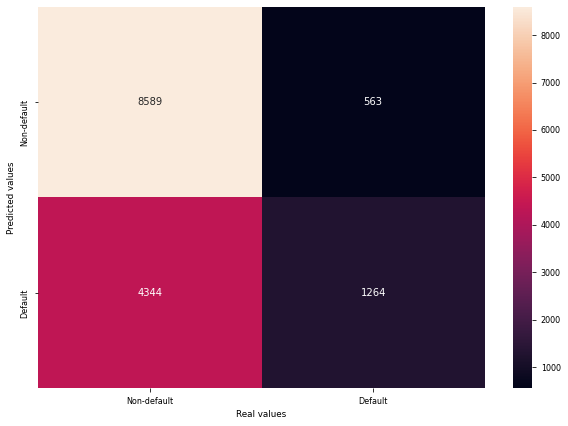

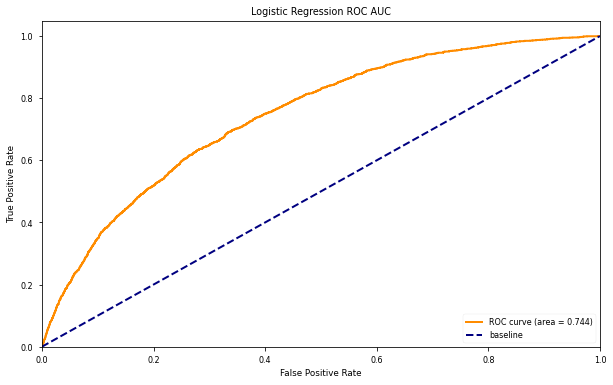

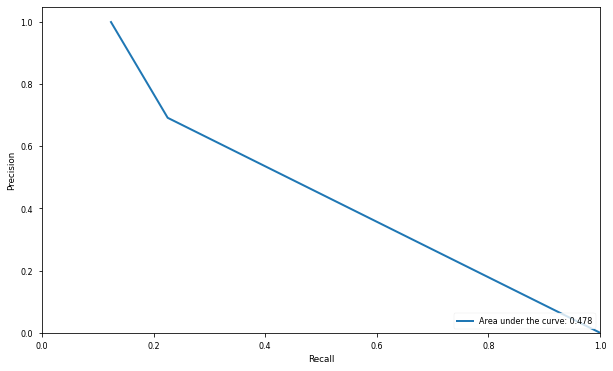

[train] F1-score = 0.34 +/- 0.00
[valid] F1-score = 0.34 +/- 0.02


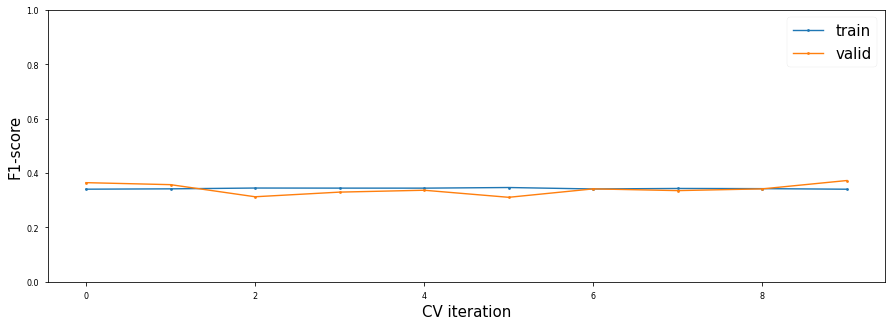

In [56]:
curr_metrics, previous_results = plot_all_metrics(y_valid, y_pred, y_pred_prob, previous_results)
display(curr_metrics)
vis_confusion_matrix(y_valid, y_pred, ['Non-default', 'Default'])
vis_roc_curve(y_valid, y_pred_prob)
vis_prec_recall_curve(y_valid, y_pred_prob)
cv_metrics = cross_validate(log_reg3, X_valid, y_valid, cv=10, scoring='f1', return_train_score=True)
vis_cv_metrics(cv_metrics)

It gave small improvement to the model. Let's use the current model for the submission. With additional time we could improve the model by fine-tuning the hyperparameters further or performing further feature engineering.

---
Это дало маленькое улучшение модели. Давайте использовать текущую модель для финального предсказания. При наличии дополнительного времени можно дальше попробовать улучшать гиперпараметры, а также добавить новые признаки.

# 5. Submission

In [57]:
train_data = df[df.train_data == 1].drop(['train_data', 'client_id', 'app_date'], axis=1)
test_data = df[df.train_data == 0].drop(['train_data', 'client_id', 'app_date'], axis=1)

In [58]:
# use all train data without splitting to train the model
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [59]:
final_model = LogisticRegression(
    random_state=RANDOM_STATE, 
    max_iter=500,
    C=7,
    class_weight= 'balanced', 
    dual= False, 
    fit_intercept= True, 
    intercept_scaling= 1, 
    l1_ratio= None, 
    multi_class= 'ovr', 
    n_jobs= None, 
    penalty= 'l2', 
    solver = 'liblinear',
    tol=0.0001,
    verbose= 0, 
    warm_start= False
  )

final_model.fit(X_train, y_train)

LogisticRegression(C=7, class_weight='balanced', max_iter=500,
                   multi_class='ovr', random_state=42, solver='liblinear')

In [60]:
y_pred_proba = final_model.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_proba
submit.to_csv('submission.csv', index=False)